In [1]:
!pip install neuron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 2.0 MB/s eta 0:00:0000:0100:01


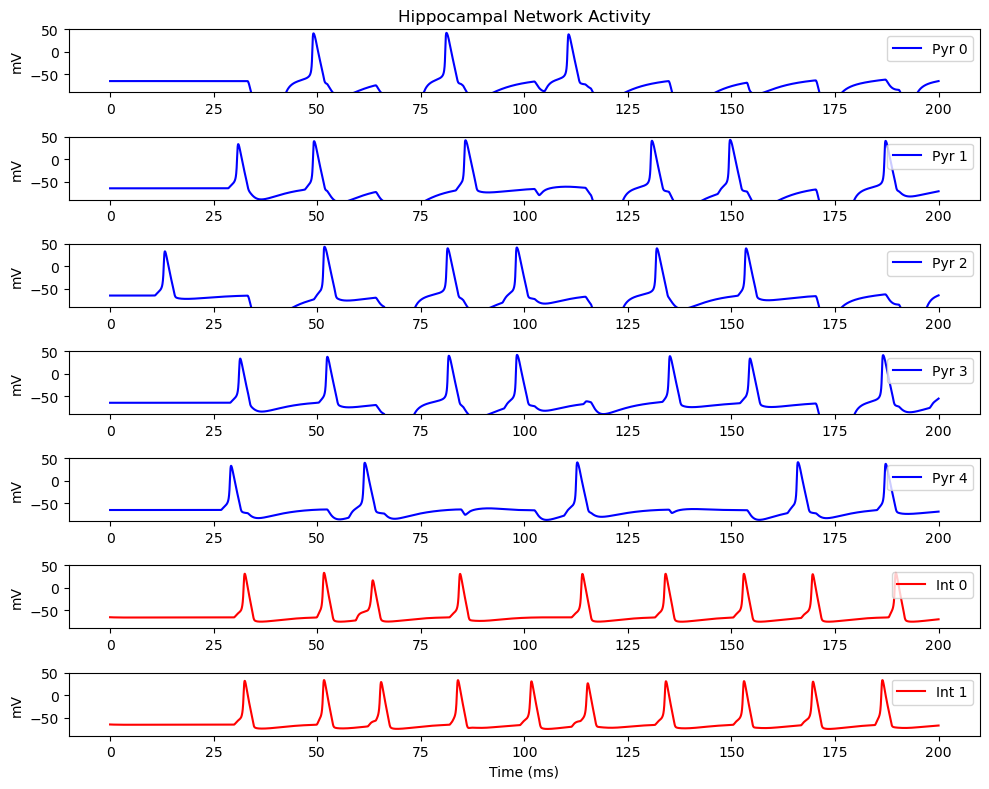

Simulation complete. Results saved to hippocampal_network_activity.png


In [2]:
"""
Hippocampal Network Simulation using NEURON
This code creates a small network of hippocampal neurons (pyramidal cells and interneurons)
with realistic biophysical properties and synaptic connections.
"""

from neuron import h
import numpy as np
import matplotlib.pyplot as plt
h.load_file("stdrun.hoc")

# Create a class for pyramidal cells (based on CA1 pyramidal cells)
class PyramidalCell:
    def __init__(self, gid):
        self.gid = gid
        
        # Create compartments
        self.soma = h.Section(name=f'soma_{gid}')
        self.dend = h.Section(name=f'dend_{gid}')
        self.apic = h.Section(name=f'apic_{gid}')
        
        # Connect sections
        self.dend.connect(self.soma(0))
        self.apic.connect(self.soma(1))
        
        # Set geometry
        self.soma.L = 20       # µm
        self.soma.diam = 20    # µm
        self.dend.L = 200      # µm
        self.dend.diam = 2     # µm
        self.apic.L = 300      # µm
        self.apic.diam = 2     # µm
        
        # Insert passive properties
        for sec in [self.soma, self.dend, self.apic]:
            sec.Ra = 150       # Ohm-cm
            sec.cm = 1         # µF/cm2
        
        # Insert active conductances - using only standard mechanisms
        self.soma.insert('hh')  # Hodgkin-Huxley mechanism
        
        # Modify HH parameters to better represent hippocampal pyramidal cells
        self.soma.gnabar_hh = 0.12    # Sodium conductance
        self.soma.gkbar_hh = 0.036    # Potassium conductance
        
        # Add passive properties to dendrites with slightly different values
        for sec in [self.dend, self.apic]:
            sec.insert('pas')
            sec.g_pas = 0.0001  # Lower conductance in dendrites
            sec.e_pas = -65     # Resting potential
        
        # Synapses and stimulation
        self.syn = h.ExpSyn(self.dend(0.5))  # Excitatory synapse
        self.syn.tau = 2       # ms
        self.syn.e = 0         # mV
        
        # For recording
        self.soma_v = h.Vector()
        self.soma_v.record(self.soma(0.5)._ref_v)
        self.t = h.Vector()
        self.t.record(h._ref_t)

# Create a class for interneurons (based on basket cells)
class Interneuron:
    def __init__(self, gid):
        self.gid = gid
        
        # Create compartments
        self.soma = h.Section(name=f'soma_{gid}')
        self.dend = h.Section(name=f'dend_{gid}')
        
        # Connect sections
        self.dend.connect(self.soma(1))
        
        # Set geometry
        self.soma.L = 15       # µm
        self.soma.diam = 15    # µm
        self.dend.L = 150      # µm
        self.dend.diam = 1.5   # µm
        
        # Insert passive properties
        for sec in [self.soma, self.dend]:
            sec.Ra = 150       # Ohm-cm
            sec.cm = 1         # µF/cm2
            
        # Insert active conductances - fast-spiking interneuron model
        self.soma.insert('hh')
        self.soma.gnabar_hh = 0.1    # High sodium conductance for fast spiking
        self.soma.gkbar_hh = 0.04    # High potassium conductance
        
        # Set passive properties in dendrites
        self.dend.insert('pas')
        self.dend.g_pas = 0.0002  # Higher conductance than pyramidal cells
        self.dend.e_pas = -65
        
        # Synapses and stimulation
        self.syn = h.ExpSyn(self.dend(0.5))  # Excitatory synapse
        self.syn.tau = 1       # ms (faster synapses than pyramidal cells)
        self.syn.e = 0         # mV
        
        # Inhibitory synapse mechanism
        self.inh_syn = h.Exp2Syn(self.soma(0.5))
        self.inh_syn.tau1 = 0.5  # ms
        self.inh_syn.tau2 = 5    # ms
        self.inh_syn.e = -75     # mV
        
        # For recording
        self.soma_v = h.Vector()
        self.soma_v.record(self.soma(0.5)._ref_v)
        self.t = h.Vector()
        self.t.record(h._ref_t)

# Create a network class
class HippocampalNetwork:
    def __init__(self, n_pyr=5, n_int=2):
        self.pyr_cells = [PyramidalCell(i) for i in range(n_pyr)]
        self.int_cells = [Interneuron(i+n_pyr) for i in range(n_int)]
        
        # Create connections between cells
        self.netcons = []
        self.stimuli = []
        
        # Connect pyramidal cells to interneurons (excitatory)
        for pyr in self.pyr_cells:
            for intr in self.int_cells:
                if np.random.random() < 0.6:  # 60% connection probability
                    nc = h.NetCon(pyr.soma(0.5)._ref_v, intr.syn, sec=pyr.soma)
                    nc.threshold = -10  # mV
                    nc.weight[0] = 0.005  # synaptic weight
                    nc.delay = 1          # ms
                    self.netcons.append(nc)
        
        # Connect interneurons to pyramidal cells (inhibitory feedback)
        for intr in self.int_cells:
            for pyr in self.pyr_cells:
                if np.random.random() < 0.7:  # 70% connection probability
                    nc = h.NetCon(intr.soma(0.5)._ref_v, pyr.syn, sec=intr.soma)
                    nc.threshold = -10  # mV
                    nc.weight[0] = -0.01  # inhibitory weight
                    nc.delay = 1          # ms
                    self.netcons.append(nc)
    
    def add_stimulus(self, target_cells="pyr", start=5, interval=20, number=5, noise=0.2):
        """Add random stimulation to the network"""
        if target_cells == "pyr":
            cells = self.pyr_cells
        else:
            cells = self.int_cells
            
        for cell in cells:
            stim = h.NetStim()
            stim.start = start
            stim.interval = interval
            stim.number = number
            stim.noise = noise
            
            nc = h.NetCon(stim, cell.syn)
            nc.weight[0] = 0.01
            nc.delay = 0
            
            self.stimuli.append(stim)
            self.netcons.append(nc)
    
    def run_simulation(self, duration=100):
        """Run the simulation for a specified duration"""
        h.tstop = duration
        h.init()
        h.run()
        
    def plot_results(self):
        """Plot voltage traces for all cells"""
        plt.figure(figsize=(10, 8))
        
        # Plot pyramidal cells
        for i, cell in enumerate(self.pyr_cells):
            plt.subplot(len(self.pyr_cells) + len(self.int_cells), 1, i+1)
            plt.plot(cell.t, cell.soma_v, 'b', label=f'Pyr {i}')
            plt.ylabel('mV')
            plt.legend(loc='upper right')
            plt.ylim(-90, 50)
            if i == 0:
                plt.title('Hippocampal Network Activity')
        
        # Plot interneurons
        for i, cell in enumerate(self.int_cells):
            plt.subplot(len(self.pyr_cells) + len(self.int_cells), 1, i+len(self.pyr_cells)+1)
            plt.plot(cell.t, cell.soma_v, 'r', label=f'Int {i}')
            plt.ylabel('mV')
            plt.legend(loc='upper right')
            plt.ylim(-90, 50)
            
        plt.xlabel('Time (ms)')
        plt.tight_layout()
        return plt.gcf()

# Execute simulation
if __name__ == "__main__":
    # Create network with 5 pyramidal cells and 2 interneurons
    network = HippocampalNetwork(n_pyr=5, n_int=2)
    
    # Add stimulation to pyramidal cells
    network.add_stimulus(target_cells="pyr", start=10, interval=30, number=10, noise=0.4)
    
    # Add some stimulation to interneurons as well
    network.add_stimulus(target_cells="int", start=15, interval=50, number=5, noise=0.5)
    
    # Run simulation for 200 ms
    network.run_simulation(duration=200)
    
    # Plot and save results
    fig = network.plot_results()
    plt.savefig("hippocampal_network_activity.png")
    plt.show()
    
    print("Simulation complete. Results saved to hippocampal_network_activity.png")